In [1]:
# Create NCSS object to access the NetcdfSubset
# Data from NOMADS GFS 0.5 deg Analysis Archive
# https://www.ncdc.noaa.gov/data-access/model-data/model-datasets/global-forcast-system-gfs
from siphon.ncss import NCSS

year = '2017'
month = '04'
day = '05'
hour = '12'
ncss = NCSS('https://nomads.ncdc.noaa.gov/thredds/ncss/grid/gfs-004-anl/201704/20170405/gfsanl_4_'
            +year+month+day+'_'+hour+'00_000.grb2')

In [2]:
# Helper function for finding proper time variable
def find_time_var(var, time_basename='time'):
    for coord_name in var.coordinates.split():
        if coord_name.startswith(time_basename):
            return coord_name
    raise ValueError('No time variable found for ' + var.name)

In [3]:
from datetime import datetime
# Create lat/lon box for location you want to get data for
query = ncss.query().time(datetime(int(year),int(month),int(day),int(hour)))
query.lonlat_box(north=65, south=15, east=310, west=220)
query.accept('netcdf4')

# Request data for vorticity
query.variables('Geopotential_height', 'Temperature',
                'U-component_of_wind', 'V-component_of_wind')
#query.vertical_level(85000)
data = ncss.get_data(query)

#Pull out variables you want to use
hght_var = data.variables['Geopotential_height']
temp_var = data.variables['Temperature']
u_wind_var = data.variables['U-component_of_wind']
v_wind_var = data.variables['V-component_of_wind']
time_var = data.variables[find_time_var(temp_var)]
lat_var = data.variables['lat']
lon_var = data.variables['lon']

In [4]:
import numpy as np
from netCDF4 import num2date
import scipy.ndimage as ndimage
from metpy.units import units

# Get actual data values and remove any size 1 dimensions
lat = lat_var[:].squeeze()
lon = lon_var[:].squeeze()
hght = hght_var[:].squeeze()
temp = temp_var[:].squeeze() * units.K
u_wind = u_wind_var[:].squeeze() * units('m/s')
v_wind = v_wind_var[:].squeeze() * units('m/s')

# Convert number of hours since the reference time into an actual date
time = num2date(time_var[:].squeeze(), time_var.units)

lev_850 = np.where(data.variables['pressure'][:] == 850*100)[0][0]
hght_850 = hght[lev_850]
temp_850 = temp[lev_850]
u_wind_850 = u_wind[lev_850]
v_wind_850 = v_wind[lev_850]

# Combine 1D latitude and longitudes into a 2D grid of locations
lon_2d, lat_2d = np.meshgrid(lon, lat)
# Gridshift for barbs
lon_2d[lon_2d > 180] = lon_2d[lon_2d > 180] - 360

In [5]:
# Helper function to calculate distance between lat/lon points
# to be used in differencing calculations
def calc_dx_dy(longitude,latitude,shape='sphere',radius=6370997.):
    ''' This definition calculates the distance between grid points that are in
        a latitude/longitude format.
        
        Using pyproj GEOD; different Earth Shapes
        https://jswhit.github.io/pyproj/pyproj.Geod-class.html
        
        Common shapes: 'sphere', 'WGS84', 'GRS80'
        
        Accepts, 1D or 2D arrays for latitude and longitude
        
        Assumes [Y, X] for 2D arrays
        
        Returns: dx, dy; 2D arrays of distances between grid points 
                 in the x and y direction with units of meters 
    '''
    import numpy as np
    from metpy.units import units
    from pyproj import Geod
    
    if (radius != 6370997.):
        g = Geod(ellps=shape, a=radius, b=radius)
    else:
        g = Geod(ellps=shape)
    
    if (latitude.ndim == 1):
        longitude, latitude = np.meshgrid(longitude,latitude)
    
    dy = np.zeros(latitude.shape)
    dx = np.zeros(longitude.shape)
        
    _, _, dy[:-1,:] = g.inv(longitude[:-1,:],latitude[:-1,:],longitude[1:,:],latitude[1:,:])
    dy[-1,:] = dy[-2,:]
    
    _, _, dx[:,:-1] = g.inv(longitude[:,:-1],latitude[:,:-1],longitude[:,1:],latitude[:,1:])
    dx[:,-1] = dx[:,-2]
    
    xdiff_sign = np.sign(longitude[0,1]-longitude[0,0])
    ydiff_sign = np.sign(latitude[1,0]-latitude[0,0])
    return xdiff_sign*dx*units.meter, ydiff_sign*dy*units.meter

In [30]:
from metpy.calc import potential_temperature

dx, dy = calc_dx_dy(lon_2d, lat_2d)

thta_850 = potential_temperature(850.*units.hPa, temp_850)

def total_deformation(uwnd, vwnd, dx, dy, dim_order='yx'):
    from metpy.calc import shearing_stretching_deformation
    shrd, strd = shearing_stretching_deformation(uwnd, vwnd, dx, dy, dim_order=dim_order)
    return np.sqrt(shrd**2+strd**2)

# Calculating Frontogenesis
def frontogenesis(thta, uwnd, vwnd, dx, dy, dim_order='yx'):
    from metpy.calc import shearing_stretching_deformation, h_convergence
    # Conversion factor to get to units of K/100km/3h
    CONV = 1.08e4 * 1e5
    
    ddy_thta = np.gradient(thta, dy, axis=0) * units('kelvin/meter') 
    ddx_thta = np.gradient(thta, dx, axis=1) * units('kelvin/meter')
    mag_thta = np.sqrt(ddx_thta**2 + ddy_thta**2)

    shrd, strd = shearing_stretching_deformation(uwnd, vwnd, dx, dy, dim_order=dim_order)
    tdef = total_deformation(uwnd, vwnd, dx, dy, dim_order=dim_order)

    div = h_convergence(uwnd, vwnd, dx, dy, dim_order=dim_order)

    psi = 0.5*np.arctan2(shrd,strd)
    beta = np.arcsin((-ddx_thta*np.cos(psi) - ddy_thta*np.sin(psi))/mag_thta)

    return 0.5 * CONV * mag_thta * (tdef * np.cos(2*beta) - div)

fronto = frontogenesis(thta_850.to('degF'), u_wind_850, v_wind_850, dx, dy)

/Users/kgoebber/anaconda3/envs/devel/lib/python3.6/site-packages/pint/quantity.py:772: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


/Users/kgoebber/anaconda3/envs/devel/lib/python3.6/site-packages/matplotlib/contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


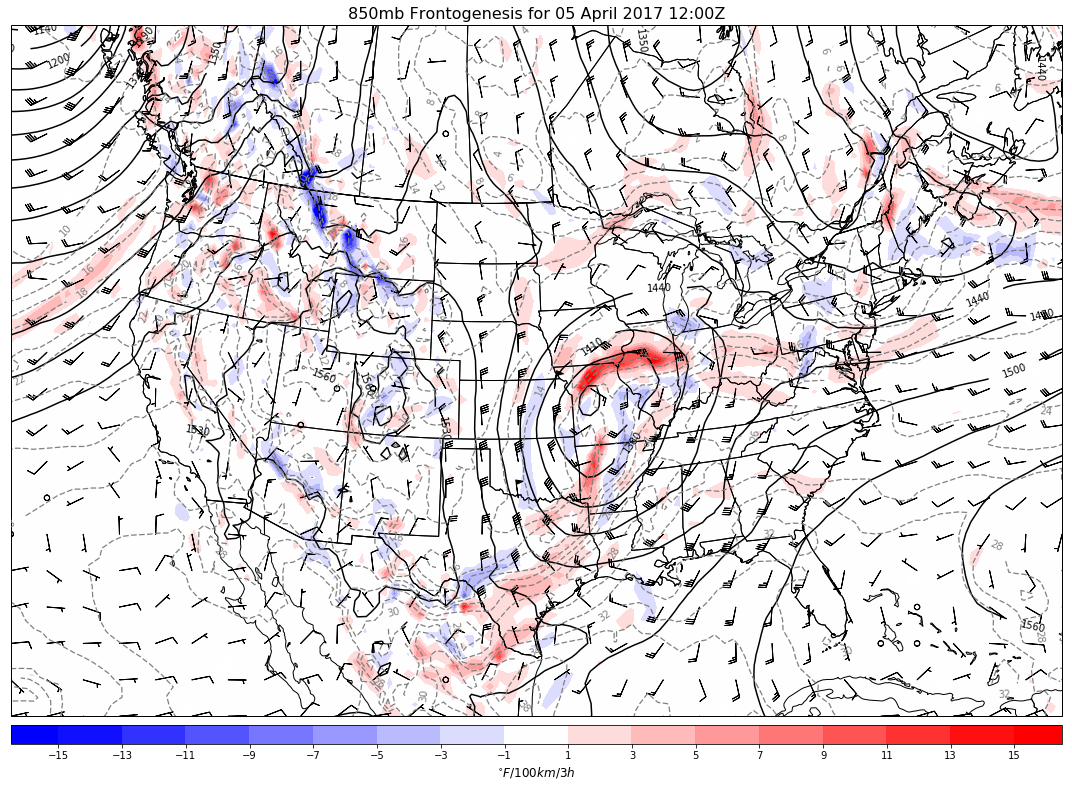

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

datacrs = ccrs.PlateCarree()
projcrs = ccrs.LambertConformal(central_latitude=[30,60],central_longitude=-100)

# Create new figure
fig = plt.figure(figsize=(15,12.2))

# Add the map and set the extent
ax = plt.axes(projection=projcrs)
ax.set_extent([235., 290., 20., 55.])

# Add state boundaries to plot
states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes',
                                                scale='50m', facecolor='none')
ax.add_feature(states_provinces, edgecolor='black', linewidth=1)

# Add country borders to plot
country_borders = cfeature.NaturalEarthFeature(category='cultural', name='admin_0_countries', 
                                               scale='50m',facecolor='none')
ax.add_feature(country_borders, edgecolor='black', linewidth=1)

# Plot Height Contours
clev850 = np.arange(900,3000,30)
cs = ax.contour(lon_2d,lat_2d,hght_850,clev850,colors='black',linewidths=1.5,linestyles='solid',
                transform=datacrs)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)

# Plot Temperature Contours
clevtemp850 = np.arange(-40,40,2)
cs2 = ax.contour(lon_2d,lat_2d,thta_850.to('degC'),clevtemp850,colors='grey',
                 linewidths=1.25,linestyles='dashed',transform=datacrs)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)

# Plot Colorfill of Temperature Advection
clev_adv = np.arange(-15,16,2)
cf = ax.contourf(lon_2d,lat_2d,fronto,clev_adv[clev_adv!=0],extend='both',cmap='bwr',
                 transform=datacrs)
cb = plt.colorbar(cf, orientation='horizontal', pad=0.01, aspect=50, extendrect=True, ticks=clev_adv)
cb.set_label(r'$^{\circ}F/100km/3h$', size='large')

# Plot Wind Barbs
ax.barbs(lon_2d,lat_2d,u_wind_850.to('knots').m,v_wind_850.to('knots').m,length=6,regrid_shape=20,
         transform=datacrs)

plt.title('850mb Frontogenesis for {0:%d %B %Y %H:%MZ}'.format(time), fontsize=16)
plt.tight_layout()
plt.show()